# TWAP Analysis

## Purpose
Explore Reflexer TWAP.

## Outline

1) Prep Data
2) Prod TWAP
3) TWAP from spot RAI/USD and spot ETH/USD
4) TWAP from spot RAI/USD and spot ETH/USD, with 1min ETH/USD sampling
5) TWAP from sport RAI/USD with 4H sampling

### Number of most recent minutes to display for all plots

In [1]:
N_PLOTS = 10000

In [2]:
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

In [3]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 200 

## Prep data

In [53]:
df_twap = pd.read_csv('twap.csv')
df_rai = pd.read_csv('rai_eth.csv')
df_eth = pd.read_csv('eth_usd.csv')

### Rename columns

In [5]:
df_twap = df_twap.rename(columns={"value": "twap_usd"})
df_rai = df_rai.rename(columns={"value": "rai_eth"})
df_eth = df_eth.rename(columns={"value": "eth_usd"})

### prod currentCoinMedianizerUpdates

RAI/USD values derived from RAI/ETH TWAP and TWAP of Chainlink spot ETH/USD. 

Time: modified time

Source: the graph systemState.

In [6]:
df_twap.head(3)

,time,twap_usd,field
0,2021-05-28T00:03:02Z,3.025544,currentCoinMedianizerUpdate
1,2021-05-28T00:05:14Z,3.025544,currentCoinMedianizerUpdate
2,2021-05-28T00:16:11Z,3.025544,currentCoinMedianizerUpdate


### Spot RAI/ETH. 

Time: modified time

Source: The graph uniswapPair

In [7]:
df_rai.head(3)

,time,rai_eth,field
0,2021-05-28T00:03:02Z,0.001096,RAI/ETH price
1,2021-05-28T00:05:14Z,0.001100,RAI/ETH price
2,2021-05-28T00:21:06Z,0.001100,RAI/ETH price


### Spot ETH/USD from Coingecko. 

Time: API query time

In [8]:
df_eth.head(3)

,time,eth_usd,field
0,2021-05-28T00:01:27Z,2742.99,ETH/USD price
1,2021-05-28T00:03:30Z,2742.92,ETH/USD price
2,2021-05-28T00:05:32Z,2742.92,ETH/USD price


### Convert `time` str to datetime 

In [9]:
df_twap['time'] = pd.to_datetime(df_twap['time'], infer_datetime_format=True)
df_rai['time'] = pd.to_datetime(df_rai['time'], infer_datetime_format=True)
df_eth['time'] = pd.to_datetime(df_eth['time'], infer_datetime_format=True)

### Round each `time` to 1 min

In [10]:
df_twap['time_1m'] = df_twap['time'].dt.round('1min') 
df_rai['time_1m'] = df_rai['time'].dt.round('1min') 
df_eth['time_1m'] = df_eth['time'].dt.round('1min') 

### Rounding might have created some duplicates, so drop those

In [11]:
df_twap = df_twap.drop_duplicates(['time_1m']) 
df_rai = df_rai.drop_duplicates(['time_1m']) 
df_eth = df_eth.drop_duplicates(['time_1m']) 

### Forward fill every minute in between. This will allow joining since each data source has a different set of timestamps

In [12]:
df_twap = df_twap.set_index('time_1m')
df_twap = df_twap.asfreq('1min', method='ffill')

df_rai = df_rai.set_index('time_1m')
df_rai = df_rai.asfreq('1min', method='ffill')

df_eth = df_eth.set_index('time_1m')
df_eth = df_eth.asfreq('1min', method='ffill')

### Join all dataframes

In [13]:
df_rai_eth = pd.merge(df_rai['rai_eth'], df_eth['eth_usd'], left_index=True, right_index=True)

In [14]:
df = pd.merge(df_rai_eth[['rai_eth', 'eth_usd']], df_twap['twap_usd'], left_index=True, right_index=True)

### Calculate spot RAI/USD from spot RAI/ETH and spot ETH/USD

In [15]:
df['rai_usd'] = df['rai_eth'] * df['eth_usd']

# TWAP #1: Compare Prod RAI/USD TWAP to RAI/USD spot

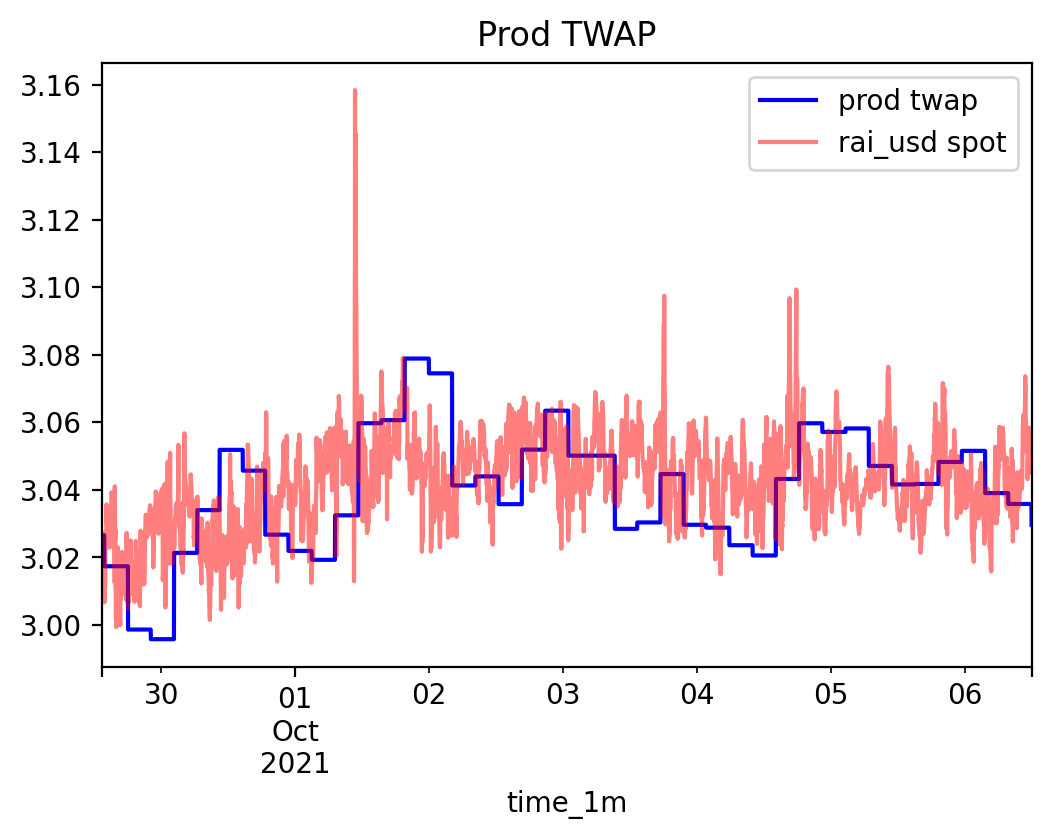

In [57]:
ax = df['twap_usd'][-N_PLOTS:].plot(color='blue', label='prod twap')
df['rai_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot')
plt.title('Prod TWAP')
plt.legend()

### Existing RAI/USD TWAP - RAI/USD Spot

Text(0.5, 1.0, 'Prod TWAP - RAI/USD Spot')

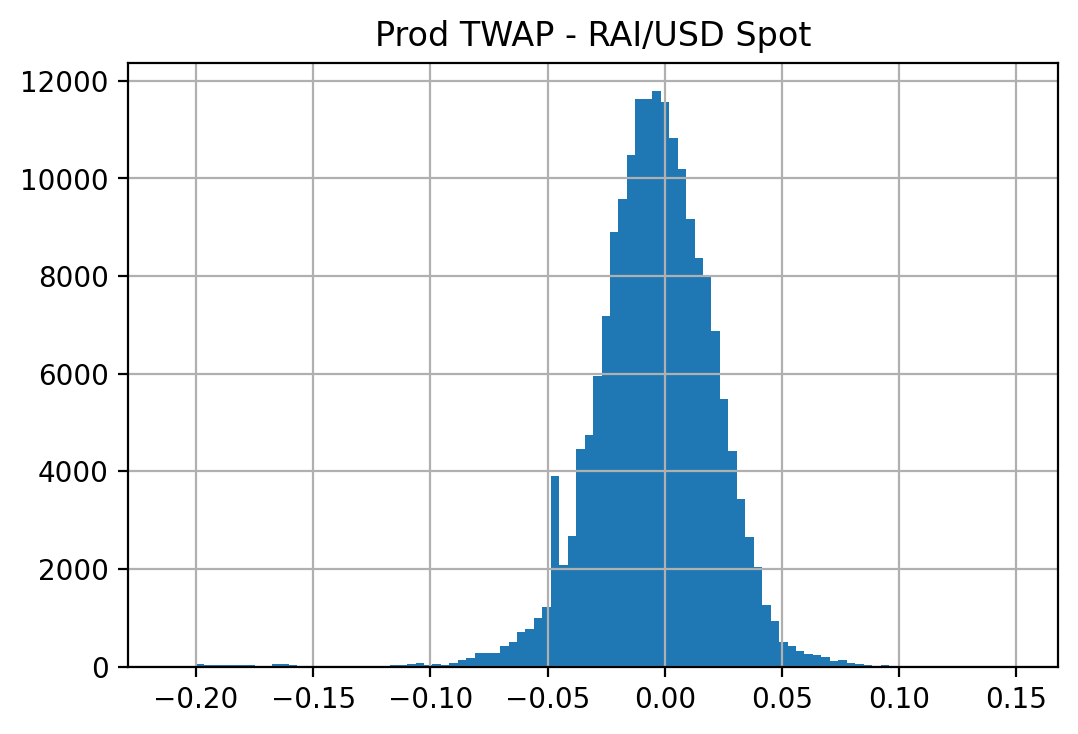

In [17]:
(df['twap_usd'] - df['rai_usd']).hist(bins=100)
plt.title("Prod TWAP - RAI/USD Spot")

# TWAP #2: Reconstruct RAI/USD TWAP from spot data

In [18]:
#df_rai_eth.head(10)

In [19]:
df.head(5)

,rai_eth,eth_usd,twap_usd,rai_usd
time_1m,,,,
2021-05-28 00:03:00,0.001096,2742.99,3.025544,3.007601
2021-05-28 00:04:00,0.001096,2742.92,3.025544,3.007524
2021-05-28 00:05:00,0.001100,2742.92,3.025544,3.016369
2021-05-28 00:06:00,0.001100,2742.92,3.025544,3.016369
2021-05-28 00:07:00,0.001100,2742.92,3.025544,3.016369


### Create RAI/ETH 16H moving average

In [20]:
df['rai_eth_16H'] = df.rolling('16H')['rai_eth'].mean()

### Get ETH/USD value every 4th hour

In [21]:
df_eth_usd_4H = df.resample('4H').first()[['eth_usd', 'rai_eth_16H']]

df_eth_usd_4H.head(10)

,eth_usd,rai_eth_16H
time_1m,,
2021-05-28 00:00:00,2742.99,0.001096
2021-05-28 04:00:00,2719.68,0.001110
2021-05-28 08:00:00,2570.08,0.001130
2021-05-28 12:00:00,2423.46,0.001154
2021-05-28 16:00:00,2561.46,0.001159
2021-05-28 20:00:00,2507.54,0.001181
2021-05-29 00:00:00,2430.35,0.001205
2021-05-29 04:00:00,2519.66,0.001205
2021-05-29 08:00:00,2498.82,0.001209


### Create 16H ETH/USD moving average

In [22]:
df_eth_usd_4H['eth_usd_16H'] = df_eth_usd_4H.rolling('16H')['eth_usd'].mean()

In [23]:
df_eth_usd_4H.head(5)

,eth_usd,rai_eth_16H,eth_usd_16H
time_1m,,,
2021-05-28 00:00:00,2742.99,0.001096,2742.990000
2021-05-28 04:00:00,2719.68,0.001110,2731.335000
2021-05-28 08:00:00,2570.08,0.001130,2677.583333
2021-05-28 12:00:00,2423.46,0.001154,2614.052500
2021-05-28 16:00:00,2561.46,0.001159,2568.670000


### Create final TWAP by multiplying 16H RAI/ETH MA with 16H ETH/USD MA

In [24]:
df_eth_usd_4H['twap_16H_usd'] = df_eth_usd_4H['rai_eth_16H'] * df_eth_usd_4H['eth_usd_16H']

### Forward fill values every min

In [25]:
df_eth_usd_4H = df_eth_usd_4H.asfreq('1min', method='ffill')

In [26]:
df_eth_usd_4H.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189121 entries, 2021-05-28 00:00:00 to 2021-10-06 08:00:00
Freq: T
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eth_usd       189121 non-null  float64
 1   rai_eth_16H   189121 non-null  float64
 2   eth_usd_16H   189121 non-null  float64
 3   twap_16H_usd  189121 non-null  float64
dtypes: float64(4)
memory usage: 7.2 MB


### Compare TWAP #2 with RAI/USD spot and 16H RAI/USD spot moving average

In [27]:
df2 = pd.merge(df, df_eth_usd_4H, left_index=True, right_index=True).drop(['eth_usd_x', 'eth_usd_y'], axis=1)

In [28]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189118 entries, 2021-05-28 00:03:00 to 2021-10-06 08:00:00
Freq: T
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   rai_eth        189118 non-null  float64
 1   twap_usd       189118 non-null  float64
 2   rai_usd        189118 non-null  float64
 3   rai_eth_16H_x  189118 non-null  float64
 4   rai_eth_16H_y  189118 non-null  float64
 5   eth_usd_16H    189118 non-null  float64
 6   twap_16H_usd   189118 non-null  float64
dtypes: float64(7)
memory usage: 11.5 MB


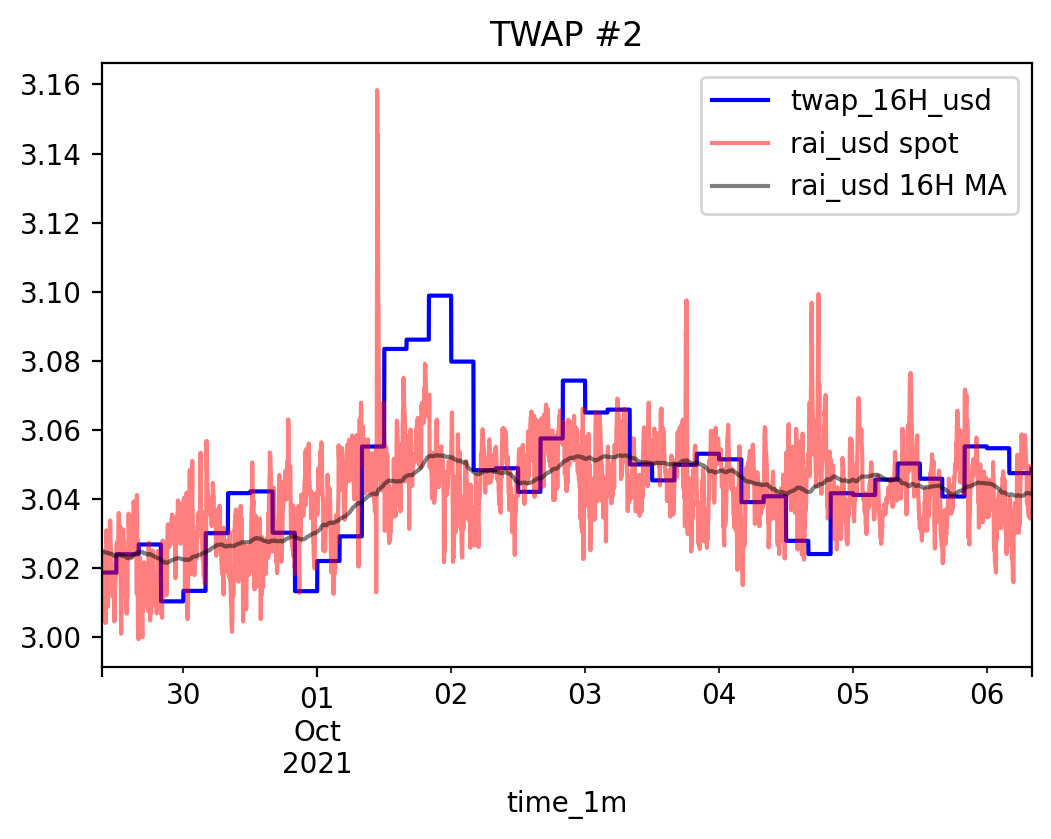

In [56]:
ax = df2['twap_16H_usd'][-N_PLOTS:].plot(color='blue')
df2['rai_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot')
df2['rai_usd'].rolling('16H').mean()[-N_PLOTS:].plot(ax=ax, alpha=0.5, color='black', label='rai_usd 16H MA')
plt.title('TWAP #2')
plt.legend()

### Compare TWAP #2 with prod RAI/USD TWAP

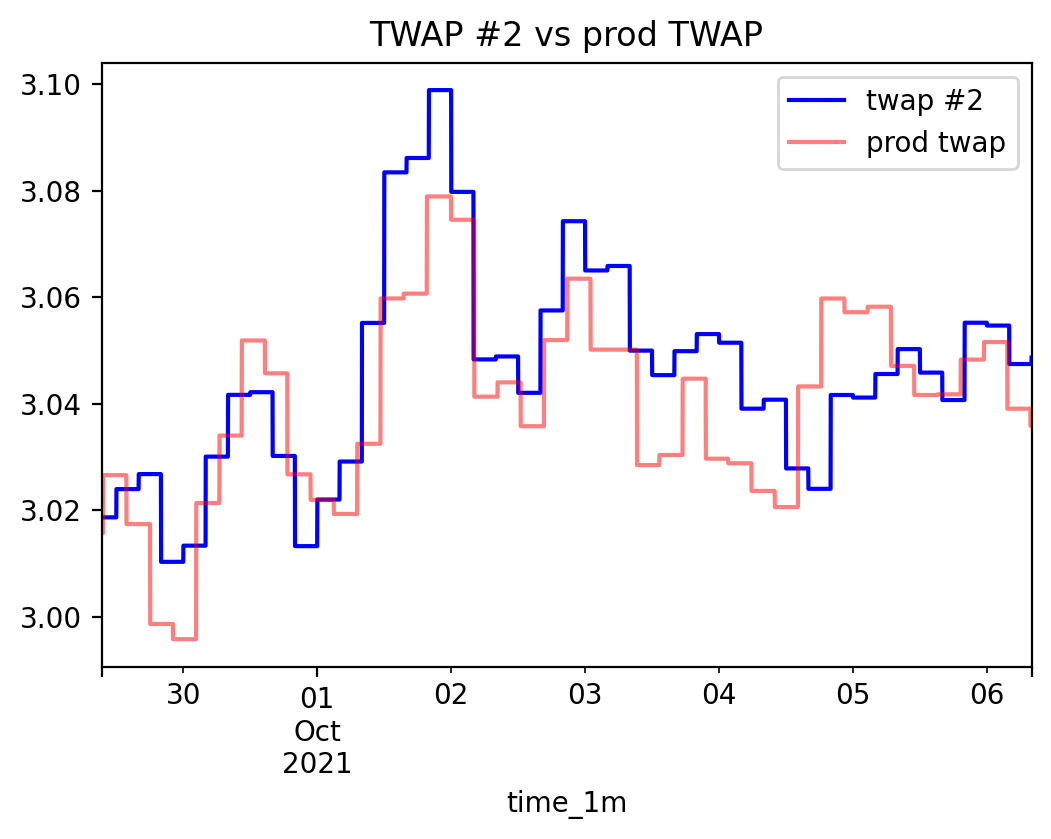

In [60]:
ax = df2['twap_16H_usd'][-N_PLOTS:].plot(color='blue', label='twap #2')
df2['twap_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='prod twap')
plt.title('TWAP #2 vs prod TWAP')
plt.legend()

### TWAP #2 - RAI/USD Spot

Text(0.5, 1.0, 'TWAP #2 - RAI/USD Spot')

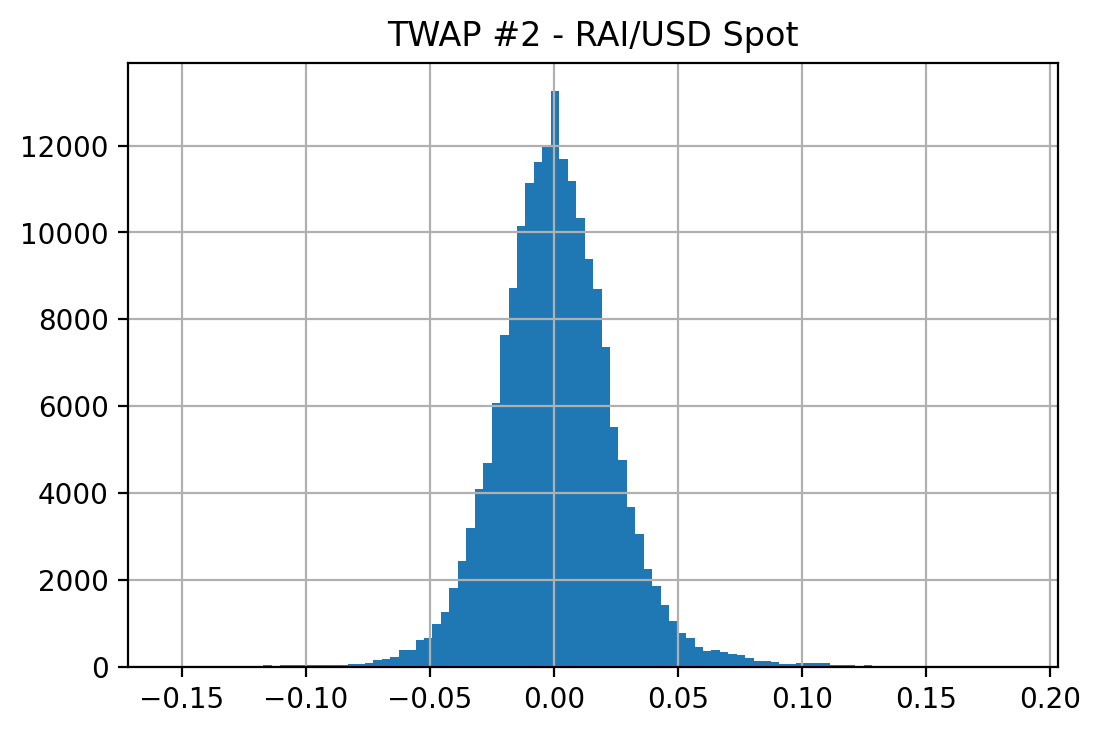

In [61]:
(df2['twap_16H_usd'] - df2['rai_usd']).hist(bins=100)
plt.title('TWAP #2 - RAI/USD Spot')

# TWAP #3: Created RAI/USD TWAP from spot prices, but with 16H ETH/USD TWAP w/ 1m data

In [33]:
df.head(5)

,rai_eth,eth_usd,twap_usd,rai_usd,rai_eth_16H
time_1m,,,,,
2021-05-28 00:03:00,0.001096,2742.99,3.025544,3.007601,0.001096
2021-05-28 00:04:00,0.001096,2742.92,3.025544,3.007524,0.001096
2021-05-28 00:05:00,0.001100,2742.92,3.025544,3.016369,0.001098
2021-05-28 00:06:00,0.001100,2742.92,3.025544,3.016369,0.001098
2021-05-28 00:07:00,0.001100,2742.92,3.025544,3.016369,0.001098


### RAI/ETH 16H TWAP

In [34]:
df['rai_eth_16H'] = df.rolling('16H')['rai_eth'].mean()

### Get ETH/USD value every 4th hour

In [35]:
df_eth_usd_1min = df.resample('1min').first()[['eth_usd', 'rai_eth_16H']]

df_eth_usd_1min.head(10)

,eth_usd,rai_eth_16H
time_1m,,
2021-05-28 00:03:00,2742.99,0.001096
2021-05-28 00:04:00,2742.92,0.001096
2021-05-28 00:05:00,2742.92,0.001098
2021-05-28 00:06:00,2742.92,0.001098
2021-05-28 00:07:00,2742.92,0.001098
2021-05-28 00:08:00,2732.15,0.001099
2021-05-28 00:09:00,2732.15,0.001099
2021-05-28 00:10:00,2710.05,0.001099
2021-05-28 00:11:00,2710.05,0.001099


### Calculate 16H ETH/USD moving average

In [36]:
df_eth_usd_1min['eth_usd_16H'] = df_eth_usd_1min.rolling('16H')['eth_usd'].mean()

In [37]:
df_eth_usd_1min.head(5)

,eth_usd,rai_eth_16H,eth_usd_16H
time_1m,,,
2021-05-28 00:03:00,2742.99,0.001096,2742.990000
2021-05-28 00:04:00,2742.92,0.001096,2742.955000
2021-05-28 00:05:00,2742.92,0.001098,2742.943333
2021-05-28 00:06:00,2742.92,0.001098,2742.937500
2021-05-28 00:07:00,2742.92,0.001098,2742.934000


### Reconstruct Prod RAI/USD TWAP by multiplying RAI/ETH TWAP with 16H ETH/USD TWAP

In [38]:
df_eth_usd_1min['twap_16H_usd'] = df_eth_usd_1min['rai_eth_16H'] * df_eth_usd_1min['eth_usd_16H']

### Forward fill values every min

In [39]:
df_eth_usd_1min = df_eth_usd_1min.asfreq('1min', method='ffill')

In [40]:
df_eth_usd_1min.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189356 entries, 2021-05-28 00:03:00 to 2021-10-06 11:58:00
Freq: T
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eth_usd       189356 non-null  float64
 1   rai_eth_16H   189356 non-null  float64
 2   eth_usd_16H   189356 non-null  float64
 3   twap_16H_usd  189356 non-null  float64
dtypes: float64(4)
memory usage: 7.2 MB


### Compare TWAP #3 with RAI/USD spot and 16H RAI/USD spot moving average

In [41]:
df3 = pd.merge(df, df_eth_usd_1min, left_index=True, right_index=True).drop(['eth_usd_x', 'eth_usd_y'], axis=1)

In [42]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189356 entries, 2021-05-28 00:03:00 to 2021-10-06 11:58:00
Freq: T
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   rai_eth        189356 non-null  float64
 1   twap_usd       189356 non-null  float64
 2   rai_usd        189356 non-null  float64
 3   rai_eth_16H_x  189356 non-null  float64
 4   rai_eth_16H_y  189356 non-null  float64
 5   eth_usd_16H    189356 non-null  float64
 6   twap_16H_usd   189356 non-null  float64
dtypes: float64(7)
memory usage: 15.6 MB


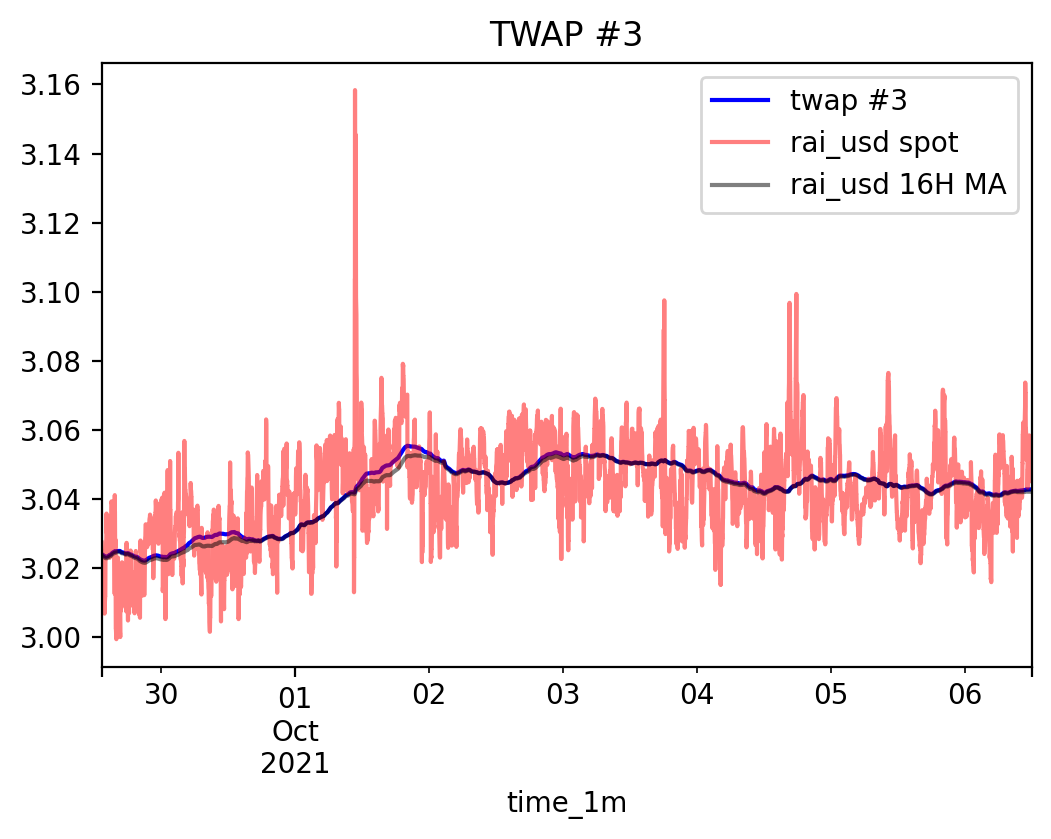

In [63]:
ax = df3['twap_16H_usd'][-N_PLOTS:].plot(color='blue', label='twap #3')
df3['rai_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot')
df3['rai_usd'].rolling('16H').mean()[-N_PLOTS:].plot(ax=ax, alpha=0.5, color='black', label='rai_usd 16H MA')
plt.title('TWAP #3')
plt.legend()

### Compare TWAP #3 with prod RAI/USD TWAP

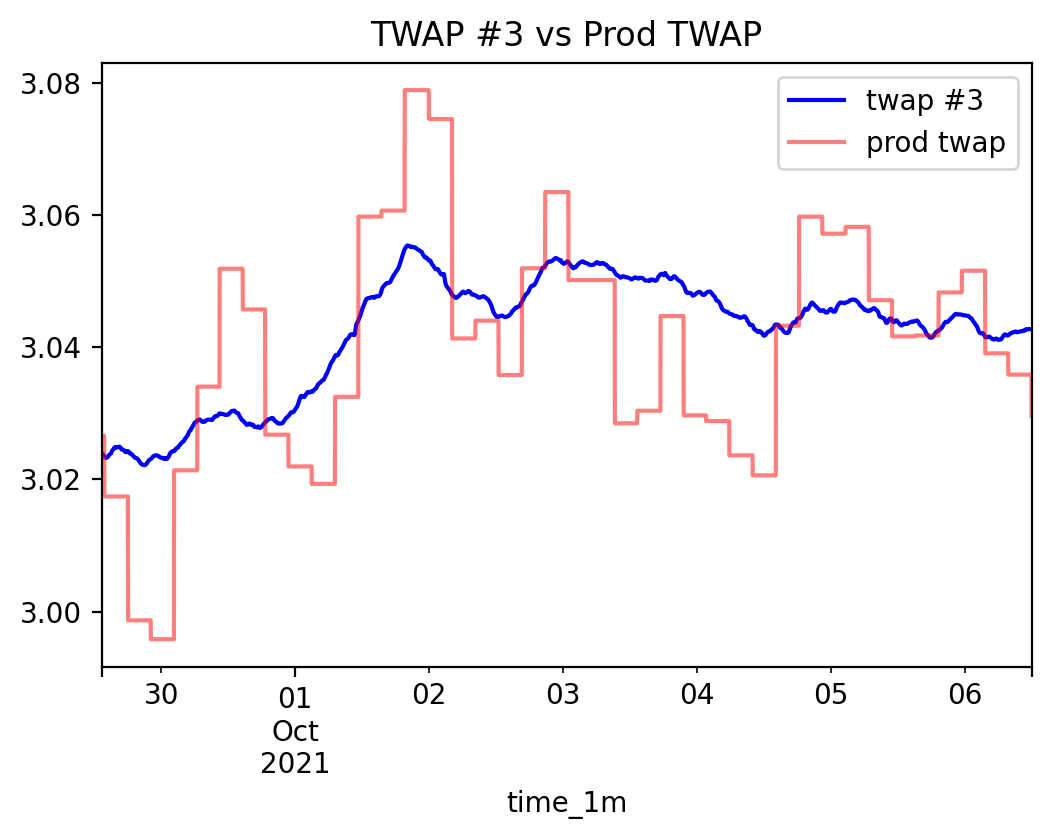

In [64]:
ax = df3['twap_16H_usd'][-N_PLOTS:].plot(color='blue', label='twap #3')
df3['twap_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='prod twap')
plt.title('TWAP #3 vs Prod TWAP')
plt.legend()

# TWAP #4: Simulate a direct RAI/USD Chainlink Feed

use RAI/USD spot and calculate 4h sampled 16h Twap

In [46]:
df_rai_usd_4H = df.resample('4H').first()[['rai_usd']]
df_rai_usd_4H.head(10)

,rai_usd
time_1m,
2021-05-28 00:00:00,3.007601
2021-05-28 04:00:00,3.017566
2021-05-28 08:00:00,3.015544
2021-05-28 12:00:00,2.981574
2021-05-28 16:00:00,3.002723
2021-05-28 20:00:00,2.996533
2021-05-29 00:00:00,3.022708
2021-05-29 04:00:00,3.007390
2021-05-29 08:00:00,2.989204


### Create 16H moving average of RAI/USD spot

In [47]:
df_rai_usd_4H['rai_usd_16H'] = df_rai_usd_4H.rolling('16H')['rai_usd'].mean()

### Forward fill every minute

In [48]:
df_rai_usd_4H = df_rai_usd_4H.asfreq('1min', method='ffill').drop('rai_usd', axis=1)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189356 entries, 2021-05-28 00:03:00 to 2021-10-06 11:58:00
Freq: T
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   rai_eth      189356 non-null  float64
 1   eth_usd      189356 non-null  float64
 2   twap_usd     189356 non-null  float64
 3   rai_usd      189356 non-null  float64
 4   rai_eth_16H  189356 non-null  float64
dtypes: float64(5)
memory usage: 12.7 MB


In [50]:
df4 = pd.merge(df, df_rai_usd_4H, left_index=True, right_index=True)

In [51]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189118 entries, 2021-05-28 00:03:00 to 2021-10-06 08:00:00
Freq: T
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   rai_eth      189118 non-null  float64
 1   eth_usd      189118 non-null  float64
 2   twap_usd     189118 non-null  float64
 3   rai_usd      189118 non-null  float64
 4   rai_eth_16H  189118 non-null  float64
 5   rai_usd_16H  189118 non-null  float64
dtypes: float64(6)
memory usage: 10.1 MB


### Compare TWAP #4 with RAI/USD spot and 16H RAI/USD spot moving average

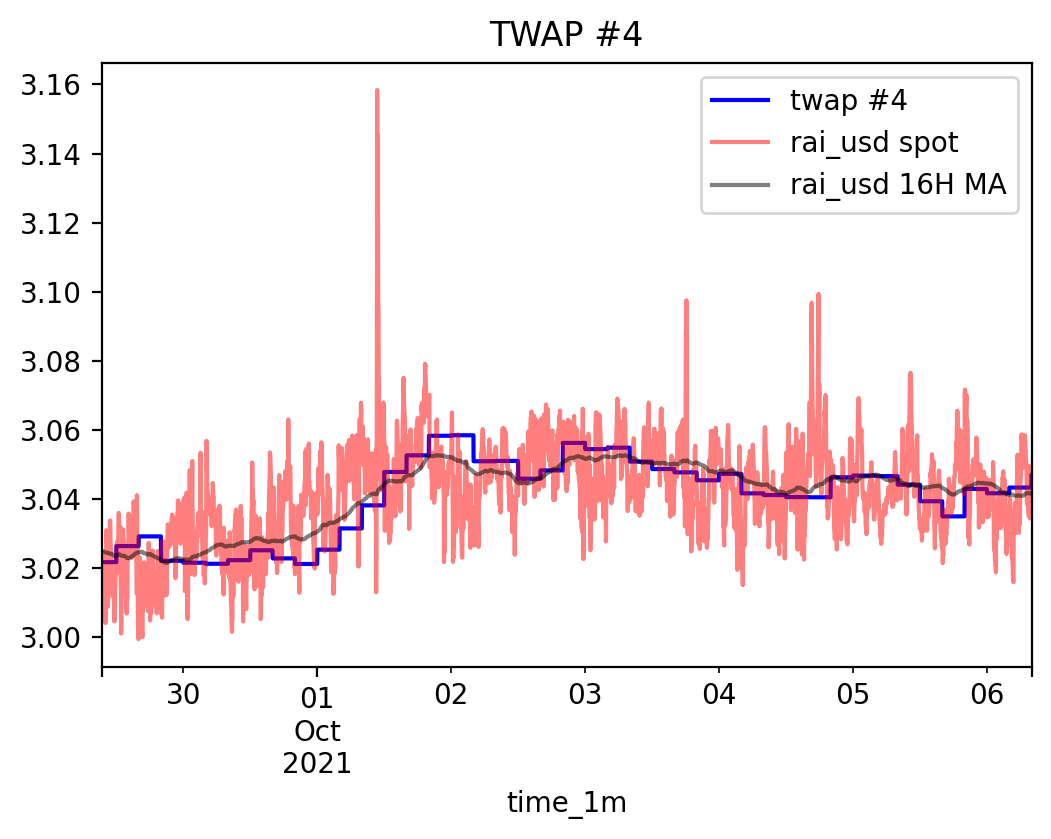

In [65]:
ax = df4['rai_usd_16H'][-N_PLOTS:].plot(color='blue', label='twap #4')
df4['rai_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='rai_usd spot')
df4['rai_usd'].rolling('16H').mean()[-N_PLOTS:].plot(ax=ax, alpha=0.5, color='black', label='rai_usd 16H MA')
plt.title('TWAP #4')
plt.legend()

### Compare TWAP #4 with prod RAI/USD TWAP

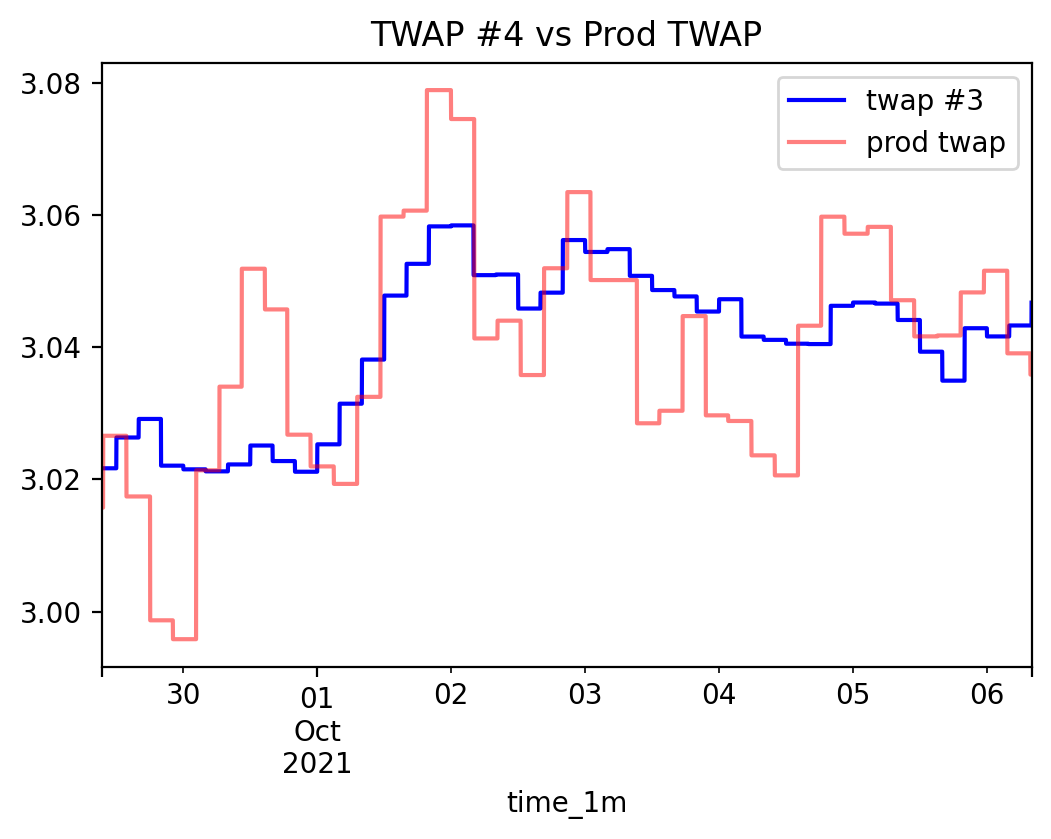

In [67]:
ax = df4['rai_usd_16H'][-N_PLOTS:].plot(color='blue', label='twap #3')
df4['twap_usd'][-N_PLOTS:].plot(ax=ax, alpha=0.5, color='red', label='prod twap')
plt.title('TWAP #4 vs Prod TWAP')
plt.legend()